<a href="https://colab.research.google.com/github/saurabh0512/kaggle_competitions/blob/master/Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
!mkdir .kaggle

In [0]:
import json
token = {"username":"sigmafactor","key":"41fab59f19122a724d4d978dbf1c0bd1"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 69.2MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 121MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 70.3MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.98MB/s]
 68% 9.00M/13.3M [00:01<00:00, 7.24MB/s]
100% 13.3M/13.3M [00:01<00:00, 8.87MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.19MB/s]


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [0]:
data_train=pd.read_csv('sales_train.csv.zip',compression='zip')
data_test=pd.read_csv('test.csv.zip',compression='zip')
data_shops=pd.read_csv('shops.csv')
data_items=pd.read_csv('items.csv.zip',compression='zip')
data_item_cat=pd.read_csv('item_categories.csv')

In [0]:
data_item_cat

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [0]:
data_train[data_train.item_cnt_day<0]['item_cnt_day'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
data_train=pd.merge(data_train,data_items,on='item_id',how='inner')

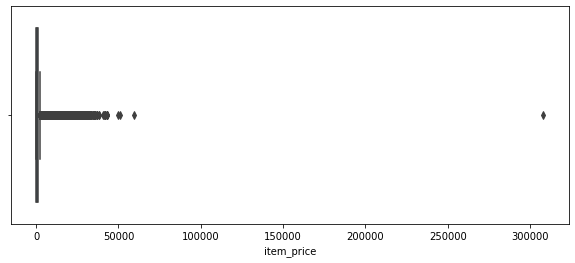

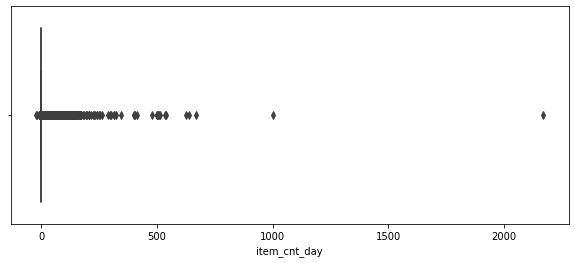

In [0]:
plt.figure(figsize=(10,4))
sns.boxplot(x=data_train['item_price'])

plt.figure(figsize=(10,4))
sns.boxplot(x=data_train['item_cnt_day'])

In [0]:
#clipping the training-data
data_train=data_train[data_train.item_price<100000]
data_train=data_train[data_train.item_cnt_day<1001]

In [0]:
#date,month,dayofweek
def get_date(data):
  data['date']=pd.to_datetime(data['date'],format='%d.%m.%Y')
  data['month']=data['date'].dt.month
  data['day']=data['date'].dt.day
  data['weekday']=data['date'].dt.dayofweek
  return data
data_train=get_date(data_train)

In [0]:
#first word of every shop represents city in which it is located
data_shops['shop_cat']=""
for i in range(0,len(data_shops['shop_name'])):
  for j in range(0,len(data_shops['shop_name'][i])):
    if data_shops['shop_name'][i][j]==" ":
      data_shops['shop_cat'][i] = data_shops['shop_name'][i][:j]   
      break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
#label encoding shop-categories
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
data_shops['shop_cat']=label.fit_transform(data_shops['shop_cat'])

#combining test and training data for processing both simultaneously.
data_combined=pd.concat([data_train[['item_id','shop_id','date_block_num']],data_test[['item_id','shop_id']]],ignore_index=False,sort=False)
data_combined.replace(np.nan,34,inplace=True)
data_combined=pd.merge(data_combined,data_shops[['shop_id','shop_cat']],on='shop_id',how='outer')

In [0]:
#first sale month of each item and differnce in months.
data=data_train.groupby('item_id').agg(start_date=('date',min)).reset_index()
data['start_month']=(data['start_date'].dt.month)-1
data_combined=pd.merge(data_combined,data[['start_month','item_id']],on='item_id',how='outer')
data_combined['month_diff']=data_combined['date_block_num']-data_combined['start_month']

In [0]:
#total items sold in each shop of particular item-id
data=data_train[['shop_id','item_id','item_cnt_day']].groupby(['item_id','shop_id']).agg(total_item_cnt_per_shop=('item_cnt_day',sum)).reset_index()
data_combined=pd.merge(data_combined,data,on=['item_id','shop_id'],how='outer')

In [0]:
#separating item category type and subtype
data_item_cat['item_cat_type']=data_item_cat['item_category_name'].str.split('-').map(lambda x: x[0])
data_item_cat['item_cat_subtype']=data_item_cat['item_category_name'].str.split('-').map(lambda x: x[-1])
data_item_cat=data_item_cat[['item_category_id','item_cat_type','item_cat_subtype']]

In [0]:
# data=data_train[['month','shop_id','item_id','item_cnt_day']].groupby(['month','item_id','shop_id']).mean().reset_index().sort_values(['month','item_id'],ascending=True)
# data=pd.merge(data,shops[['shop_id','shop_cat']],how='inner',on='shop_id')
# data=pd.merge(data,data_items,how='inner',on='item_id')
# data=data.drop('item_name',axis=1)
# data.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)

In [0]:
# def get_price_block(data):
#   bins=(0,200,400,900,350000)
#   labels=[0,1,2,3]
#   categories=pd.cut(data.item_price ,bins ,labels=labels)
#   data['price_block']=categories
#   return data
# data=get_price_block(data)
# data['price_block']=data['price_block'].astype('int64')

In [0]:
# def get_demand(data):
#   bins=(0,1,5,10,15,30,60)
#   labels=[0,1,2,3,4,5]
#   categories=pd.cut(data.item_cnt_month, bins, labels=labels)
#   data['demand']=categories
#   return data
# data=get_demand(data)

In [0]:
#average price of particular item
data=data_train[['item_price','item_id','month']].groupby('item_id').agg(item_price_avg=('item_price','mean'),month=('month','mean')).reset_index()
data_combined=pd.merge(data_combined,data,on='item_id',how='outer')
data_items=pd.merge(data_items[['item_id','item_category_id']],data_item_cat,on='item_category_id',how='inner')
data_combined=pd.merge(data_combined,data_items,on='item_id',how='inner')
data_combined['month']=round(data_combined['month'])

In [0]:
#label encoding item category
data_combined['item_cat_type']=label.fit_transform(data_combined['item_cat_type'])
data_combined['item_cat_subtype']=label.fit_transform(data_combined['item_cat_subtype'])

In [0]:
#for null entries in item_cnt_per_shop
data=data_combined[data_combined.isna().any(axis=1)]
data_1=data_combined[['total_item_cnt_per_shop','item_category_id']].dropna()
data_1=data_1.groupby('item_category_id').mean().reset_index()
data=data.drop('total_item_cnt_per_shop',axis=1)
data=pd.merge(data,data_1,on='item_category_id',how='inner')
data['total_item_cnt_per_shop']=round(data['total_item_cnt_per_shop'],0)

In [0]:
#for null entries in start_month
data_1=data[data.isna().any(axis=1)]
data_2=data_combined[['start_month','item_category_id','item_price_avg','month']].dropna()
data_2=data_2.groupby('item_category_id').mean().reset_index()
data_1.drop(['start_month','item_price_avg','month'],axis=1,inplace=True)
data_1=pd.merge(data_1,data_2,on='item_category_id',how='inner')
data_1['start_month']=round(data_1['start_month'])
data_1['item_price_avg']=round(data_1['item_price_avg'])
data_1['month']=round(data_1['month'])
data_1['month_diff']=data_1['date_block_num']-data_1['start_month']

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#combining data
data=data.dropna()
data=pd.concat([data,data_1],axis=0,sort=False)
data_combined=data_combined.dropna()
data_combined=pd.concat([data_combined,data],axis=0,sort=False)

In [0]:
# data_train[(data_train.item_cnt_day<1)&(data_train.month==11)]['item_cnt_day'].value_counts()

In [0]:
# price_train=pd.get_dummies(data['price_block'],prefix='price')
# price_test=pd.get_dummies(data_test['price_block'],prefix='price')
# data=pd.concat([data,price_train],axis=1)
# data_test=pd.concat([data_test,price_test],axis=1)

In [0]:
# data=data.drop('price_block',axis=1)
# data_test=data_test.drop('price_block',axis=1)

In [0]:
X_train=data_combined[data_combined.date_block_num<33]
X_valid=data_combined[data_combined.date_block_num==33]
X_test=data_combined[data_combined.date_block_num==34]
y_train=data_train[data_train.date_block_num<33]['item_cnt_day']
y_valid=data_train[data_train.date_block_num==33]['item_cnt_day']

In [0]:
# from sklearn.svm import SVR
# support=SVR(kernel='linear')
# support.fit(X_train[:1000],y_train[:1000])

In [0]:
import xgboost as xgb

dtrain=xgb.DMatrix(data=X_train,label=y_train)
dtest=xgb.DMatrix(data=X_test)
dvalid=xgb.DMatrix(data=X_valid,label=y_valid)
param=dict(objective='reg:squarederror',eval_metric='rmse',max_depth=5,verbosity=1,eta=0.1,min_child_weight=50)
watchlist = [( dtrain, 'train'),( dvalid, 'valid')]
model=xgb.train(param,dtrain,100,watchlist,early_stopping_rounds=10,verbose_eval=10)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:2.36914	valid-rmse:2.85957
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:2.24347	valid-rmse:2.78649
[20]	train-rmse:2.21776	valid-rmse:2.77894
[30]	train-rmse:2.2093	valid-rmse:2.77892
Stopping. Best iteration:
[24]	train-rmse:2.21342	valid-rmse:2.7781



In [0]:
# from sklearn.metrics import mean_squared_error
# prediction_valid=model.predict(dvalid)
# print("ERROR:{}".format(np.sqrt(mean_squared_error(prediction_valid,y_valid))))

In [0]:
model.get_fscore()

{'date_block_num': 74,
 'item_cat_subtype': 50,
 'item_category_id': 51,
 'item_id': 256,
 'item_price_avg': 208,
 'month_diff': 14,
 'shop_id': 58,
 'start_month': 121,
 'total_item_cnt_per_shop': 189}

In [0]:
prediction_test=model.predict(dtest)
my_submission=pd.DataFrame(data={'ID':data_test.ID.values,'item_cnt_month':prediction_test})

In [0]:
my_submission.to_csv('submission.csv',index=False)

In [0]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission.csv -m "Message"

100% 3.34M/3.34M [00:00<00:00, 7.54MB/s]
Successfully submitted to Predict Future Sales